In [137]:
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, BasicAer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_bloch_multivector
import pandas as pd
#import matplotlib as mpl
from math import pi
import numpy as np
from qiskit import QuantumCircuit, transpile

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# IBMQ.save_account('0c5f09afe94bb9159f65f3ae983bdad4fd4fe1ef0fe97a1f9167ffc44c733c5ccb21d848987d3c1796fc3a40e2143fc5f902ddb2526a3df548c3b0ea53cba38f')
# provider = IBMQ.load_account()

## Oracle 

Black box which can point out the data we are looking for without explicitally 

In [99]:
def Oracle(n,sol,m):
    
    qc = QuantumCircuit(n)
    
    for ix in range(m):
        if(sol[ix]<2**n):
          
            for q in range(n):
                if (((sol[ix] >> q) & 1) == 0):
                    qc.x(q)

            ctr = []
            for k in range(n-1):
                ctr.append(k)

            qc.h(n-1)
            qc.mct(ctr,n-1)
            qc.h(n-1)

            for qi in range(n):
                if (((sol[ix] >> qi) & 1) == 0):
                    qc.x(qi)
                
    Or = qc.to_gate()
    Or.name = 'Oracle'
    
    qc.barrier()
    
    return Or

## Diffuser

After the oracle the next thing that comes is the diffuser circuit. The overall operation can be written as 
$$
-A.S_0.A^{\\dag}
$$
where A is the matrix that produces the initial state. And $A^{\\dag}$ is the inverse. FUrtherore $S_0$ is the unitary which flips |11...11> to -|11....11>. Together they flip all the states about mean of the amplitudes. 

This cures our original problem of having weird stuff happen when the solution was not present in the data set. 

**New Porblem** - sometimes changing the no. of iterations actually changes the results. If you extract '2' out of 0,1,2,3 superpostion. No. of reps = 1 and 4 works fine but no. of reps = 2 and 3 gives us the equa; superposition state. 


In [212]:
def A(n):
    
    qc = QuantumCircuit(n)
    # input whatever the state you want as the input
          
#     qc.ry(np.pi/4, 1)
#     qc.rx(np.pi/3 , 0)
#     qc.rz(np.pi/3 , 2)
#     qc.rz(np.pi/3 , 3)
    #qc.x(0)
    
    for i in range(n-1):
        qc.h(i)
    
    
    return qc

In [207]:
def Ad(n):
    
    # no need to change this automaticlly becomes A_dag
    qc = A(n)
    
      
    qc_g = qc.to_gate(label = 'Adag')
    AAd = qc_g.inverse()
    AAd.name = '$A^{\\dag}$'
    
    return AAd

In [208]:
def S_0(n):
    
    ## one big probem in rohans code was that he has not initialise theqc so 
    ## it was taking values from other circuits

    qc = QuantumCircuit(n)
    ctr = []
    for k in range(1,n):
        ctr.append(k)


    qc.barrier()
    qc.x(list(range(n)))
    qc.h(0)
    qc.mct(ctr,0)
    qc.h(0)
    qc.x(list(range(n)))

    qc.barrier()

    
    
    return qc

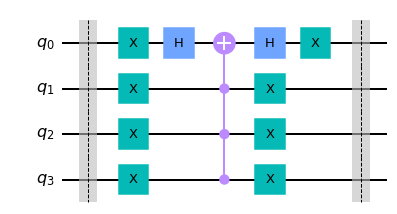

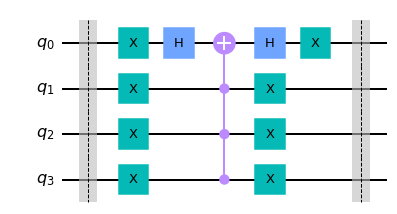

In [209]:
S_0(4).draw('mpl')

In [210]:
# get custom solutions for ex getting even numbers:

def sol(n):
    sol = []
    for i in range(n):
        if i%2==0:
            sol.append(i)
    return sol        


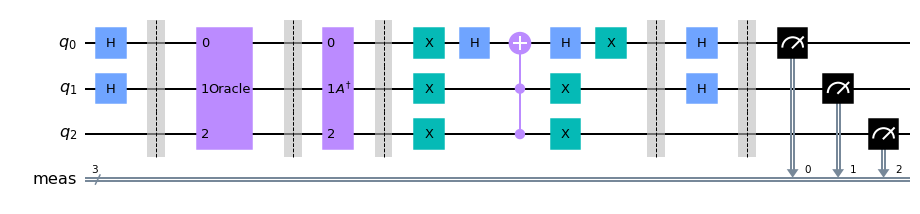

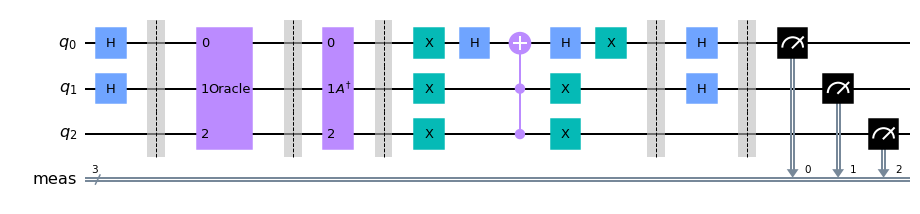

In [213]:
sol = [5]

#sol = [16,18,19]

m = 1
n = 3

qc1 = QuantumCircuit(n)

#Preparing initial state (A|0>)

#qc.h(0)

def num_iterations(m, n):
    amplitude = np.sqrt(m/(2**n))
    return round(np.arccos(amplitude) / (2 * np.arcsin(amplitude)))

#reps = num_iterations(m, n)
reps = 1

# #qc.append(A(n),list(range(n)))

## here is the initial state
qc1  = qc1.compose(A(n))
# qc1.x(0)
# qc1.h(1)
# qc1.h(2)


# # qc.h(1)
# # qc.h(2)
# # qc.h(0)

for rep in range(reps):
    qc1.barrier()
#qc.h(1)
#     qc.h(2)
#     qc.x(0)
    
    
    
    qc1.append(Oracle(n, sol, m), list(range(n)))
    
# #     qc.h(1)
# #     qc.h(2)
# #     qc.x(0)
    
    qc1.barrier()
    qc1.append(Ad(n),list(range(n)))
    
    
    qc1  = qc1.compose(Diff(n))
    qc1  = qc1.compose(A(n))
    

    

qc1.measure_all()

qc1.draw('mpl')

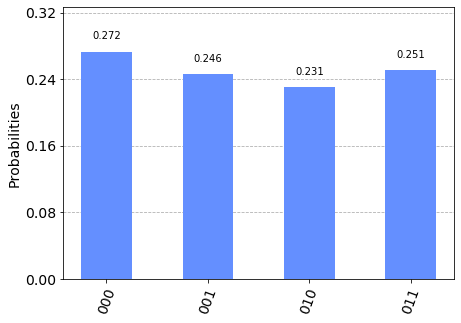

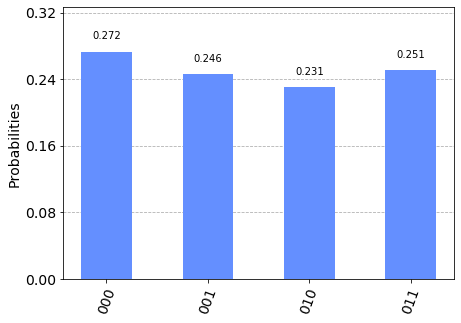

In [214]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc1,backend,shots = 1000)
counts = job.result().get_counts()
plot_histogram(counts)

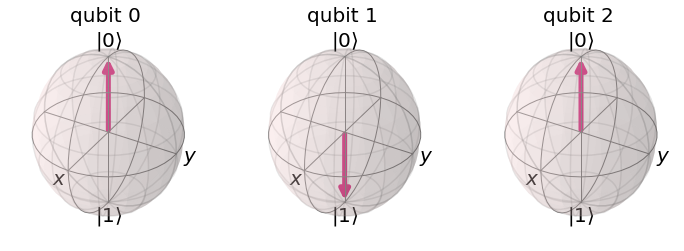

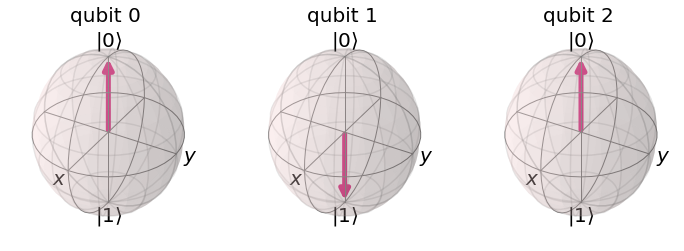

In [161]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc1, backend)
state = job.result().get_statevector()
plot_bloch_multivector(state)

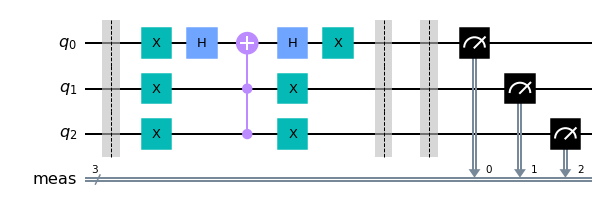

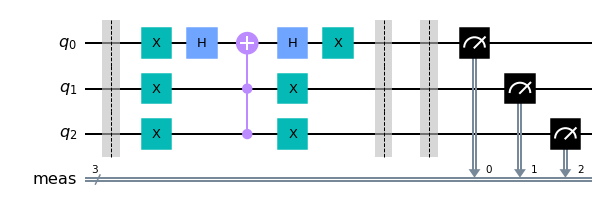

In [191]:
n = 3
qc2 = QuantumCircuit(n)
#qc2  = qc2.compose(Ad(n))
qc2  = qc2.compose(Diff(n))
#qc2.h([0,1,2])
qc2.measure_all()
qc2.draw('mpl')

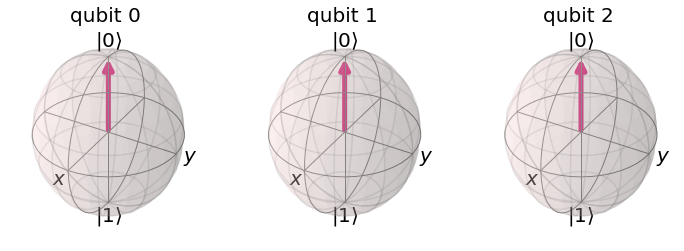

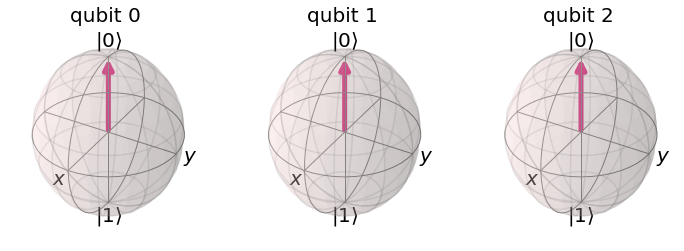

In [192]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc2, backend)
state = job.result().get_statevector()
plot_bloch_multivector(state)

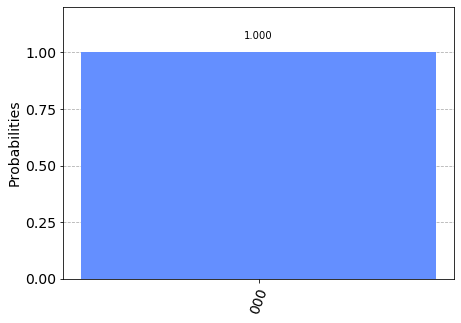

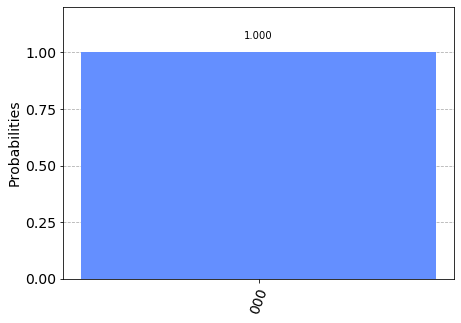

In [193]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc2,backend,shots = 1000)
counts = job.result().get_counts()
plot_histogram(counts)